In [1]:
#download kaggle key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivaanikabilan","key":"c39ea810b497b1491953c8b60efc6ce1"}'}

In [2]:
#install kaggle API
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json -p ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#creating directory
#changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
#searching for datase on kaggle
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  
---------------------------------  ----------------------  -----  -------------------  -------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05            213  


In [6]:
#download kaggle dataset
#come out of the directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 685M/691M [00:04<00:00, 170MB/s]
100% 691M/691M [00:04<00:00, 153MB/s]
/content


In [7]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
# Important library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [9]:
# Read the labels.csv file and checking shape and first 5 records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head() 

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

In [11]:
breed_counts

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [13]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 244.53it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [14]:
# Building the Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        25104     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 8)         3

In [15]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [16]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 38s 2s/step - loss: 4.9063 - accuracy: 0.3164 - val_loss: 4.8860 - val_accuracy: 0.2769
Epoch 2/100
2/2 [==============================] - 1s 516ms/step - loss: 4.8794 - accuracy: 0.3164 - val_loss: 4.8623 - val_accuracy: 0.2769
Epoch 3/100
2/2 [==============================] - 1s 507ms/step - loss: 4.8546 - accuracy: 0.3164 - val_loss: 4.8396 - val_accuracy: 0.2769
Epoch 4/100
2/2 [==============================] - 1s 513ms/step - loss: 4.8293 - accuracy: 0.3164 - val_loss: 4.8149 - val_accuracy: 0.2769
Epoch 5/100
2/2 [==============================] - 1s 513ms/step - loss: 4.8045 - accuracy: 0.3164 - val_loss: 4.7901 - val_accuracy: 0.2769
Epoch 6/100
2/2 [==============================] - 1s 513ms/step - loss: 4.7802 - accuracy: 0.3164 - val_loss: 4.7685 - val_accuracy: 0.2769
Epoch 7/100
2/2 [==============================] - 1s 514ms/step - loss: 4.7556 - accuracy: 0.3164 - val_loss: 4.7451 - val_accuracy: 0.2923
Epoch 8/100
2/2

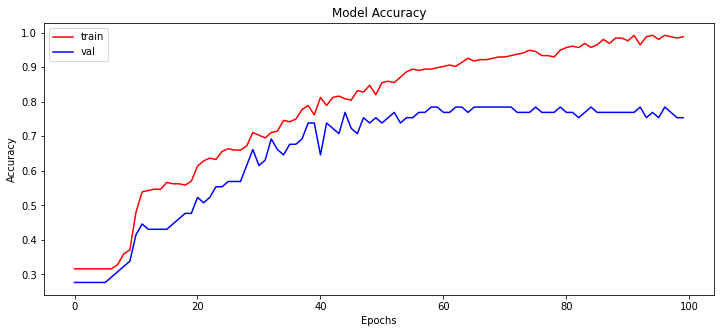

In [17]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [18]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 16ms/step - loss: 3.0662 - accuracy: 0.8056
Accuracy over the test set: 
  80.56 %


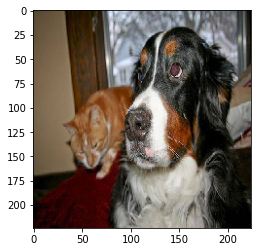

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [20]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[3])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[3])])

In [23]:
model.save("dog_breed.h5")